<a href="https://colab.research.google.com/github/MStamirski/News/blob/main/Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import random as rnd

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.layers.rnn.simple_rnn import SimpleRNN
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.metrics import Precision
from keras.metrics import Recall
from matplotlib import pyplot as plt

# Read prepared dataset

In [ ]:
allnews = pd.read_csv("drive/MyDrive/Colab_Notebooks/SDA_upskill/News/data/AllNews.csv")
allnews

,real,news
0,1,kandi burruss explodes rape accusation real ho...
1,1,people choice award 2018 best red carpet look
2,1,sophia bush send sweet birthday message one tr...
3,1,colombian singer maluma spark rumour inappropr...
4,1,gossip girl 10 year later upper east siders sh...
...,...,...
139657,1,fully commit nato back new us approach afghani...
139658,1,lexisnexis withdraw two product chinese market
139659,1,minsk cultural hub become authority
139660,1,vatican upbeat possibility pope francis visit ...


# Features based on assumed vocabulary size and sentence length

In [ ]:
VOCAB_SIZE = 10000
DIMENSIONS = 20
SENT_MAX_LENGTH = 20

In [ ]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE)
tokenizer.fit_on_texts(allnews['news'])
print(f"Tokens found: {len(tokenizer.word_index)}")

Tokens found: 39842


In [ ]:
sequences = tokenizer.texts_to_sequences(allnews['news'])
X_matrix = pad_sequences(sequences, maxlen = SENT_MAX_LENGTH)
X_matrix

array([[   0,    0,    0, ..., 5804, 2870, 1416],
       [   0,    0,    0, ...,  460, 1028,  111],
       [   0,    0,    0, ..., 1473, 3355, 8600],
       ...,
       [   0,    0,    0, ..., 4377,  377, 1728],
       [   0,    0,    0, ..., 2222,  176,   21],
       [   0,    0,    0, ...,  744,   63, 1399]], dtype=int32)

In [ ]:
X_matrix.shape

(139662, 20)

In [ ]:
features = ['feat'+str(i+1) for i in range(SENT_MAX_LENGTH)]
X = pd.DataFrame(data=X_matrix, columns=features)
X

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2599,552,1422,247,5804,2870,1416
1,0,0,0,0,0,0,0,0,0,0,0,0,64,617,196,157,200,460,1028,111
2,0,0,0,0,0,0,0,0,0,5534,483,347,1632,610,353,48,3305,1473,3355,8600
3,0,0,0,0,0,0,0,0,0,0,0,0,0,5421,1403,1549,4609,2794,514,7513
4,0,0,0,0,0,0,0,3586,253,372,51,2038,5078,761,230,101,127,2112,2259,3270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139657,0,0,0,0,0,0,0,0,0,0,0,0,3183,955,734,36,2,3,2912,1009
139658,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2127,142,1859,795,699
139659,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3525,4377,377,1728
139660,0,0,0,0,0,0,0,0,0,0,0,0,0,2324,6306,3334,700,2222,176,21


In [ ]:
y = allnews['real']
y

0         1
1         1
2         1
3         1
4         1
         ..
139657    1
139658    1
139659    1
139660    1
139661    1
Name: real, Length: 139662, dtype: int64

# Real or fake prodiction using neural networks with Embedding layer

In [ ]:
def train_val_test_split(X, y, threshold):
  df = pd.concat([y, X], axis=1)

  df_test = df.sample(frac=threshold, random_state=42)
  
  df_train_val = df.drop(df_test.index)
  df_val = df_train_val.sample(frac=threshold, random_state=42)
  
  df_train = df_train_val.drop(df_val.index)
  
  y_test = df_test.iloc[:,0]
  X_test = df_test.iloc[:,1:]

  y_val = df_val.iloc[:,0]
  X_val = df_val.iloc[:,1:]

  y_train = df_train.iloc[:,0]
  X_train = df_train.iloc[:,1:]

  return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [ ]:
def describe_dataset(title, df):
  string1 = f"{title}: X length: {len(df[0])}, "
  string2 = f"X width: {len(df[0].columns)}, "
  string3 = f"y length: {len(df[1])}, "
  string4 = f"value count {df[1].value_counts(normalize=True).index[0]}: {round(df[1].value_counts(normalize=True)[0],2)}, "
  string5 = f"value count {df[1].value_counts(normalize=True).index[1]}: {round(df[1].value_counts(normalize=True)[1],2)}"
  print(string1 + string2 + string3 + string4 + string5)

In [ ]:
train, val, test = train_val_test_split(X, y, 0.2)

In [ ]:
describe_dataset('TRAIN', train)

TRAIN: X length: 89384, X width: 20, y length: 89384, value count 1: 0.46, value count 0: 0.54


In [ ]:
describe_dataset('VALID', val)

VALID: X length: 22346, X width: 20, y length: 22346, value count 1: 0.46, value count 0: 0.54


In [ ]:
describe_dataset('TEST ', test)

TEST : X length: 27932, X width: 20, y length: 27932, value count 1: 0.45, value count 0: 0.55


In [ ]:
def plot_history(history):
  hist = history.history
  
  fig, ax = plt.subplots(figsize=[8,6])
  ax.grid()
  ax.plot(hist['loss'], 'r',linewidth=3.0, label='training')
  ax.plot(hist['val_loss'], 'b',linewidth=3.0, label='validation')
  ax.set_xlabel('Epochs')
  ax.legend()
  ax.set_title('Loss function')
  plt.show()

  fig, ax = plt.subplots(figsize=[8,6])
  ax.grid()
  ax.plot(hist['precision'], 'r',linewidth=3.0, label='training')
  ax.plot(hist['val_precision'], 'b',linewidth=3.0, label='validation')
  ax.set_xlabel('Epochs')
  ax.legend()
  ax.set_title('Precision')
  plt.show()

  fig, ax = plt.subplots(figsize=[8,6])
  ax.grid()
  ax.plot(hist['recall'], 'r',linewidth=3.0, label='training')
  ax.plot(hist['val_recall'], 'b',linewidth=3.0, label='validation')
  ax.set_xlabel('Epochs')
  ax.legend()
  ax.set_title('Recall')
  plt.show()

## 3 Dense layers

In [ ]:
model1 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=DIMENSIONS, input_length=SENT_MAX_LENGTH, name='embedding'),
    Flatten(name='flatten'),
    Dense(128, activation ='tanh', name='dense1'),
    Dense(32, activation ='tanh', name='dense2'),
    Dense(1, activation ='sigmoid', name='output')
], name='model1')

In [ ]:
model1.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')]
              )
model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            200000    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense1 (Dense)              (None, 128)               51328     
                                                                 
 dense2 (Dense)              (None, 32)                4128      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 255,489
Trainable params: 255,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model1.fit(train[0], 
                    train[1], 
                    epochs=10, 
                    # batch_size=32, 
                    validation_data=(val[0], val[1]), 
                    verbose=1
                    )

Epoch 1/10
2794/2794 [==============================] - 12s 4ms/step - loss: 0.6317 - precision: 0.5908 - recall: 0.7540 - val_loss: 0.6272 - val_precision: 0.5837 - val_recall: 0.7604
Epoch 2/10
2794/2794 [==============================] - 12s 4ms/step - loss: 0.5954 - precision: 0.6271 - recall: 0.7116 - val_loss: 0.6081 - val_precision: 0.5785 - val_recall: 0.7791
Epoch 3/10
2794/2794 [==============================] - 11s 4ms/step - loss: 0.5687 - precision: 0.6591 - recall: 0.6712 - val_loss: 0.6212 - val_precision: 0.5795 - val_recall: 0.6445
Epoch 4/10
2794/2794 [==============================] - 11s 4ms/step - loss: 0.5410 - precision: 0.6854 - recall: 0.6598 - val_loss: 0.6903 - val_precision: 0.5781 - val_recall: 0.5384
Epoch 5/10
2794/2794 [==============================] - 11s 4ms/step - loss: 0.5140 - precision: 0.7065 - recall: 0.6609 - val_loss: 0.7403 - val_precision: 0.6441 - val_recall: 0.3431
Epoch 6/10
2794/2794 [==============================] - 11s 4ms/step - loss

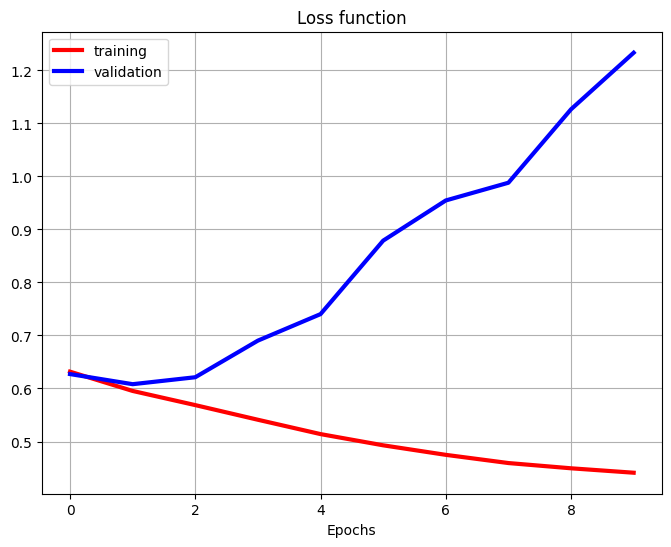

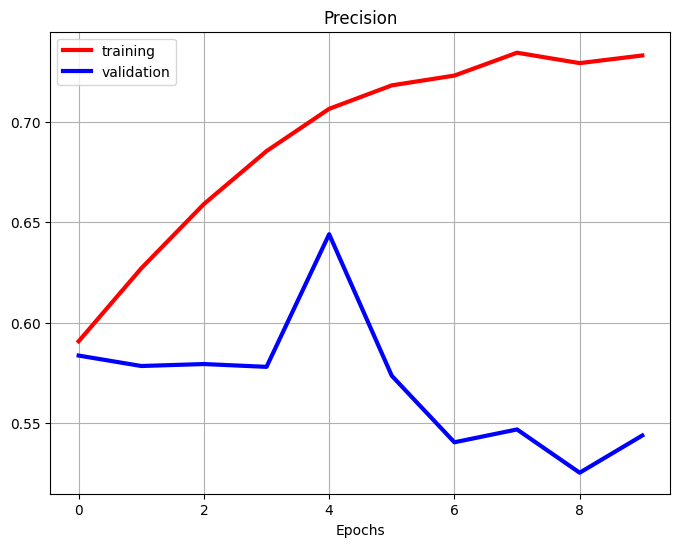

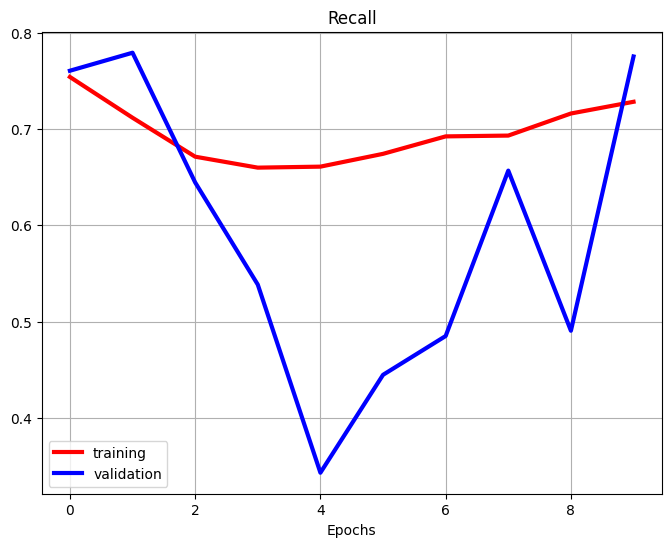

In [ ]:
plot_history(history)

## 1 SimpleRNN layer

In [ ]:
model2 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=DIMENSIONS, input_length=SENT_MAX_LENGTH, name='embedding'),
    SimpleRNN(20, name='RNN'),
    Dense(1, activation ='sigmoid', name='output')
], name='model2')

In [ ]:
model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')]
              )
model2.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            200000    
                                                                 
 RNN (SimpleRNN)             (None, 20)                820       
                                                                 
 output (Dense)              (None, 1)                 21        
                                                                 
Total params: 200,841
Trainable params: 200,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model2.fit(train[0], 
                    train[1], 
                    epochs=10, 
                    validation_data=(val[0], val[1]), 
                    verbose=1
                    )

Epoch 1/10
2794/2794 [==============================] - 19s 7ms/step - loss: 0.6283 - precision: 0.5895 - recall: 0.7496 - val_loss: 0.6096 - val_precision: 0.5785 - val_recall: 0.9741
Epoch 2/10
2794/2794 [==============================] - 17s 6ms/step - loss: 0.5879 - precision: 0.6316 - recall: 0.6874 - val_loss: 0.6082 - val_precision: 0.5903 - val_recall: 0.6391
Epoch 3/10
2794/2794 [==============================] - 17s 6ms/step - loss: 0.5674 - precision: 0.6566 - recall: 0.6745 - val_loss: 0.6262 - val_precision: 0.5696 - val_recall: 0.7272
Epoch 4/10
2794/2794 [==============================] - 19s 7ms/step - loss: 0.5491 - precision: 0.6724 - recall: 0.6771 - val_loss: 0.6418 - val_precision: 0.5667 - val_recall: 0.8192
Epoch 5/10
2794/2794 [==============================] - 18s 6ms/step - loss: 0.5321 - precision: 0.6829 - recall: 0.6900 - val_loss: 0.6848 - val_precision: 0.5799 - val_recall: 0.4602
Epoch 6/10
2794/2794 [==============================] - 19s 7ms/step - loss

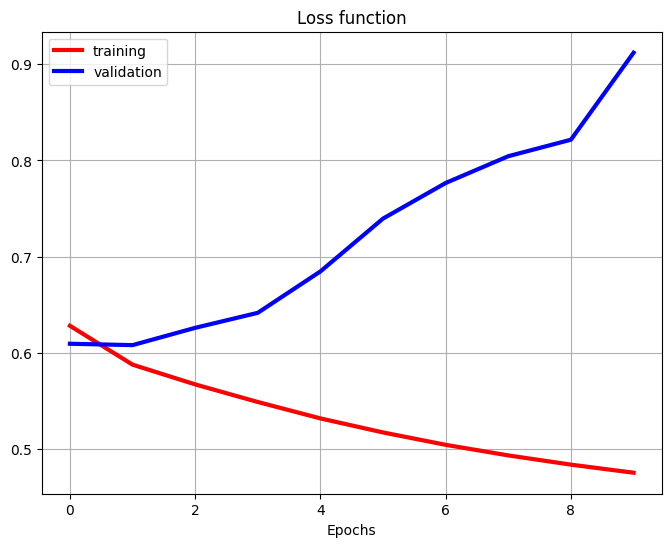

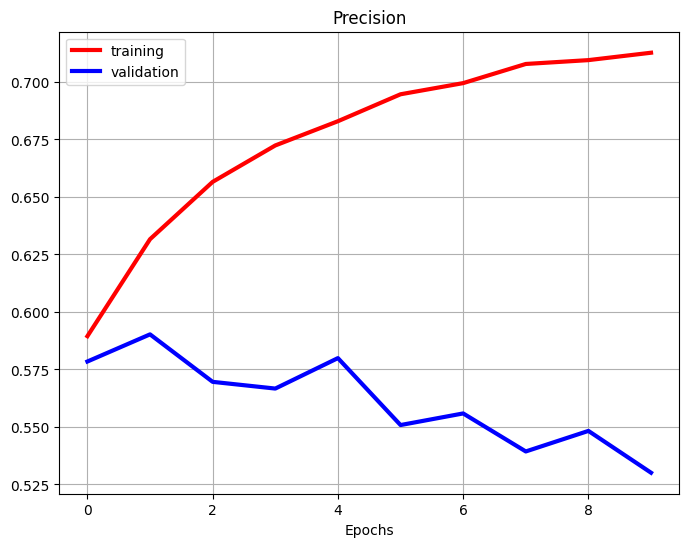

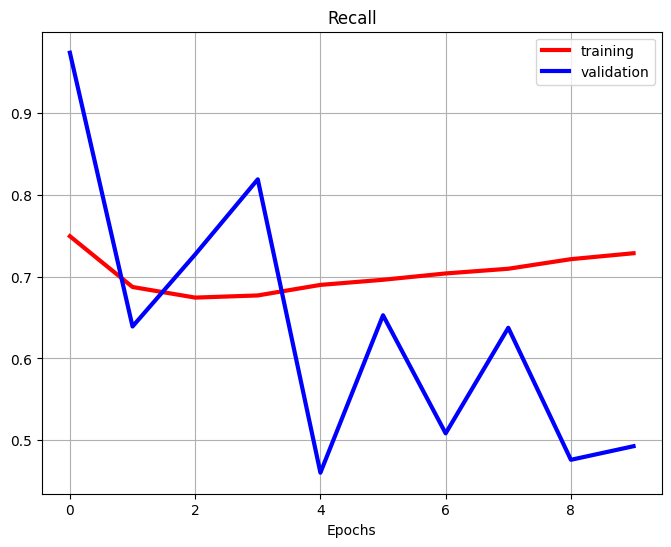

In [ ]:
plot_history(history)

## more SimpleRNN and Dropout layers

In [ ]:
model3 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=DIMENSIONS, input_length=SENT_MAX_LENGTH, name='embedding'),
    SimpleRNN(20, return_sequences=True, name='RNN1'),
    Dropout(0.2, name='dropout1'),
    SimpleRNN(20, return_sequences=True, name='RNN2'),
    SimpleRNN(20, name='RNN3'),
    Dropout(0.2, name='dropout2'),
    Dense(1, activation ='sigmoid', name='output')
], name='model3')

In [ ]:
model3.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[Precision(name='precision'), Recall(name='recall')]
              )
model3.summary()

Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            200000    
                                                                 
 RNN1 (SimpleRNN)            (None, 20, 20)            820       
                                                                 
 dropout1 (Dropout)          (None, 20, 20)            0         
                                                                 
 RNN2 (SimpleRNN)            (None, 20, 20)            820       
                                                                 
 RNN3 (SimpleRNN)            (None, 20)                820       
                                                                 
 dropout2 (Dropout)          (None, 20)                0         
                                                                 
 output (Dense)              (None, 1)                 21   

In [ ]:
history = model3.fit(train[0], 
                    train[1], 
                    epochs=10, 
                    validation_data=(val[0], val[1]), 
                    verbose=1
                    )

Epoch 1/10
2794/2794 [==============================] - 56s 14ms/step - loss: 0.6403 - precision: 0.5919 - recall: 0.7178 - val_loss: 0.6136 - val_precision: 0.5829 - val_recall: 0.8517
Epoch 2/10
2794/2794 [==============================] - 36s 13ms/step - loss: 0.5983 - precision: 0.6256 - recall: 0.6931 - val_loss: 0.6080 - val_precision: 0.5792 - val_recall: 0.8788
Epoch 3/10
2794/2794 [==============================] - 37s 13ms/step - loss: 0.5775 - precision: 0.6450 - recall: 0.6852 - val_loss: 0.6161 - val_precision: 0.6112 - val_recall: 0.5434
Epoch 4/10
2794/2794 [==============================] - 35s 12ms/step - loss: 0.5590 - precision: 0.6626 - recall: 0.6819 - val_loss: 0.6343 - val_precision: 0.5668 - val_recall: 0.8064
Epoch 5/10
2794/2794 [==============================] - 36s 13ms/step - loss: 0.5408 - precision: 0.6784 - recall: 0.6819 - val_loss: 0.6723 - val_precision: 0.6234 - val_recall: 0.4127
Epoch 6/10
2794/2794 [==============================] - 36s 13ms/step 

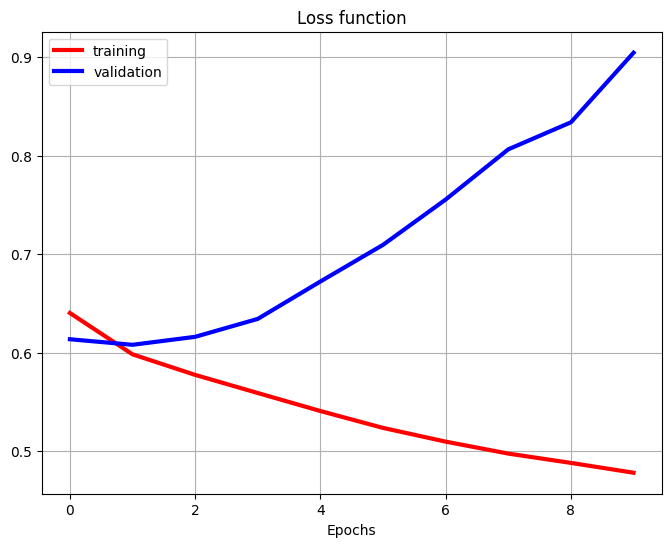

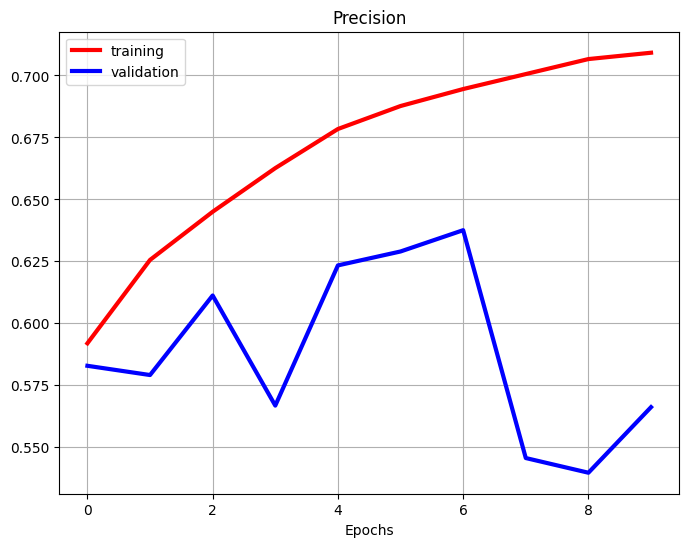

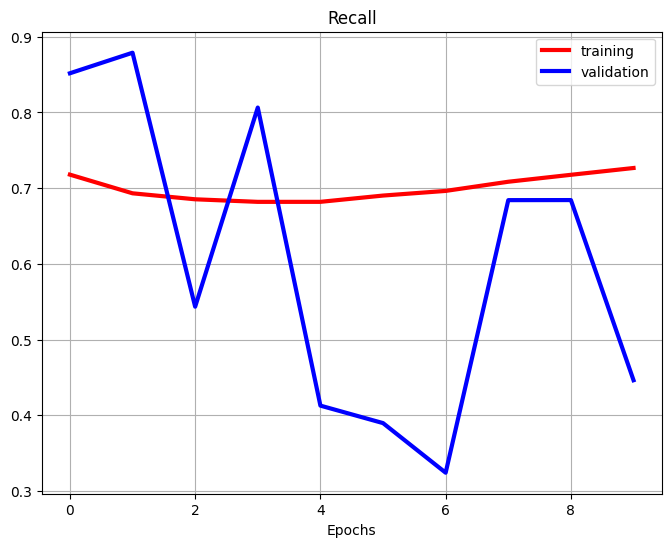

In [ ]:
plot_history(history)

# Prediction of 3 models on test dataset

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
def predict_test_news(model, test):
  prediction = model.predict(test[0])
  pred_int = [int(round(pred,0)) for pred in prediction[:,0]]

  print(f"\nPrecision: {precision_score(test[1], pred_int):.2f}")
  print(f"Recall:    {recall_score(test[1], pred_int):.2f}")
  print(f'F1:        {f1_score(test[1], pred_int):.2f}\n')
  
  cm = confusion_matrix(test[1], pred_int)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["FAKE", "REAL"])
  cm_display.plot()
  plt.show()

873/873 [==============================] - 1s 1ms/step

Precision: 0.55
Recall:    0.77
F1:        0.64



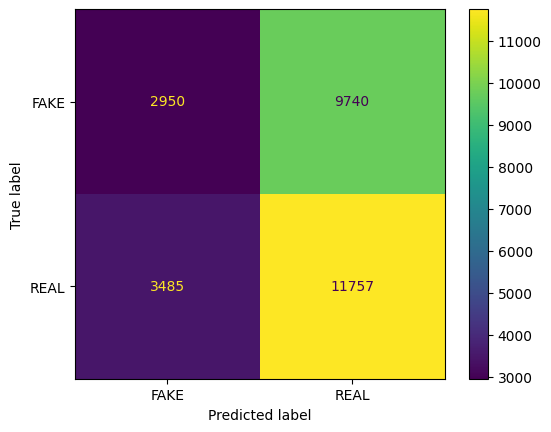

In [ ]:
predict_test_news(model1, test)

873/873 [==============================] - 2s 2ms/step

Precision: 0.53
Recall:    0.50
F1:        0.52



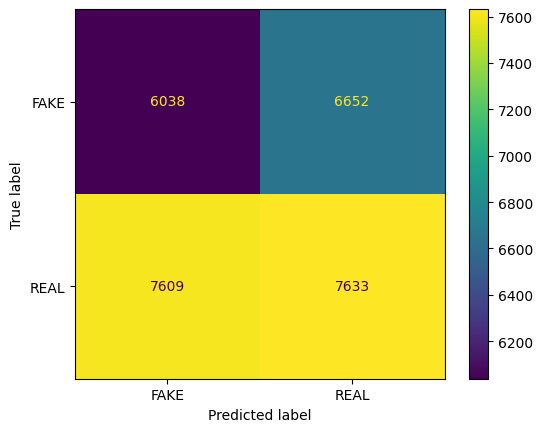

In [ ]:
predict_test_news(model2, test)

873/873 [==============================] - 3s 3ms/step

Precision: 0.57
Recall:    0.45
F1:        0.50



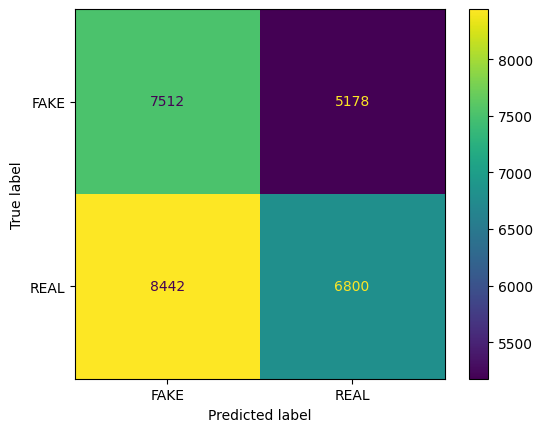

In [ ]:
predict_test_news(model3, test)

# Summary

Number of features resulted from unified length of sentences (25 words). Value of each feature was an index in vocabulary of word in sentence. Vocabulary size was limited to 10.000 of words, out of total almost 40.000. Used embedding model transformed each sentence to vector of 20 numbers. Then three neural network models were tested. Unfortunatelly, as learning curves show, number of features turned out to be unsufficient. The best model, with 3 dense layers and without RNN and Dropout layers, gave F1 score of only 0.64.